=== Prefix Sums Snapshot ===
Series length: 1254 days
Last cumulative (simple): 2.6359
Last cumulative (via log): 2.6142
Max drawdown: -0.4204 from 2021-11-19 to 2023-01-05
Compounded return over last 60 sessions (prefix O(1)): 0.0553

Saved:
 - C:\Users\adity\Downloads\Learn_DSA_Quant\Level-22\prefix_cum_returns_drawdown.csv
 - C:\Users\adity\Downloads\Learn_DSA_Quant\Level-22\prefix_cumulative_contributions.csv


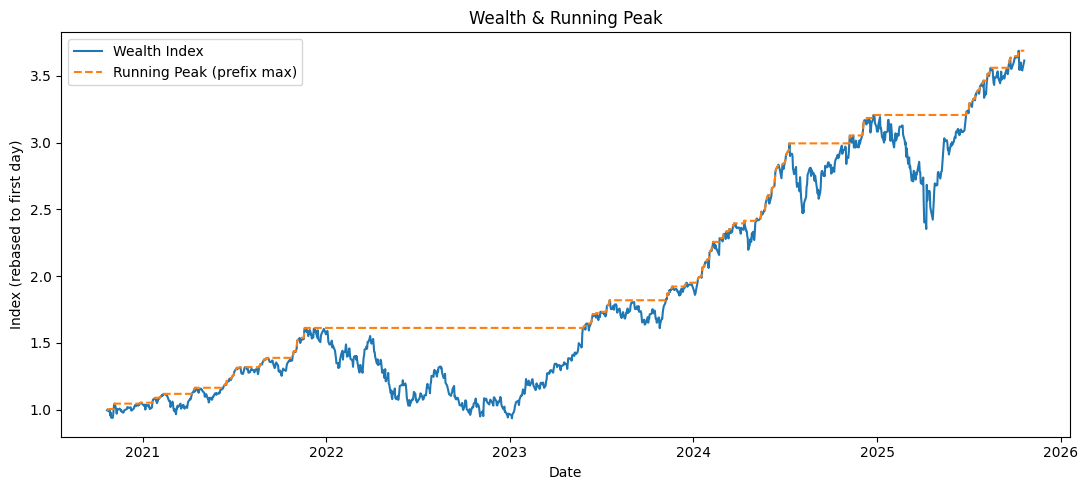

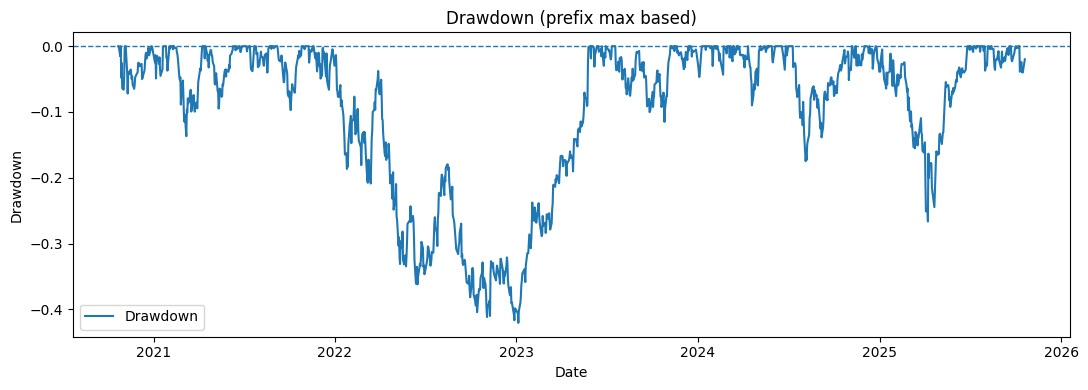

In [1]:
# Step 22 — Prefix Sums + Cumulative Returns & Drawdowns (one cell, hardened)

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional, Tuple

# ------------------------ User Params ------------------------
TICKERS: List[str] = ["AAPL", "MSFT", "NVDA", "AMZN"]  # portfolio tickers
WEIGHTS: Optional[Dict[str, float]] = None             # e.g., {"AAPL":0.3,"MSFT":0.3,"NVDA":0.2,"AMZN":0.2}
LOOKBACK_YEARS: int = 5
OUT_DIR = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-22")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------ Helpers ------------------------
def to_1d(a) -> np.ndarray:
    return np.asarray(a, dtype=float).reshape(-1)

def last_scalar(a) -> float:
    arr = to_1d(a)
    return float(arr[-1]) if arr.size else float("nan")

def download_adj_close(tickers: List[str], years=3) -> pd.DataFrame:
    period = f"{years}y"
    try:
        df = yf.download(" ".join(tickers), period=period, interval="1d",
                         auto_adjust=True, progress=False)
        if df.empty:
            return pd.DataFrame()
        if isinstance(df.columns, pd.MultiIndex):
            px = df["Close"].copy() if "Close" in df.columns.get_level_values(0) else df.xs(df.columns.levels[0][-1], axis=1, level=0)
        else:
            # Single ticker -> ensure a DataFrame with the ticker name
            px = df[["Close"]].copy()
            px.columns = [tickers[0]]
        # tidy
        px = px.dropna(how="all").ffill().dropna(how="any")
        return px
    except Exception:
        return pd.DataFrame()

def make_synthetic(tickers: List[str], years=3, seed=22) -> pd.DataFrame:
    np.random.seed(seed)
    n = years*252
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    data = {}
    for t in tickers:
        mu = 0.10 + 0.04*np.random.randn()
        vol = 0.22 + 0.06*np.random.randn()
        dt = 1/252
        ret = (mu - 0.5*vol**2)*dt + vol*np.sqrt(dt)*np.random.randn(n)
        data[t] = 100*np.exp(np.cumsum(ret))
    return pd.DataFrame(data, index=dates)

def normalize_weights(tickers: List[str], weights: Optional[Dict[str,float]]) -> pd.Series:
    if not weights:
        w = pd.Series(1.0/len(tickers), index=tickers, dtype=float)
    else:
        w = pd.Series({t: weights.get(t, 0.0) for t in tickers}, dtype=float)
        s = w.sum()
        w = w if s == 0 else (w / s)
        if s == 0:
            w[:] = 1.0/len(tickers)
    return w

# ---- Prefix-sum utilities ----
def prefix_sum(arr: np.ndarray) -> np.ndarray:
    """Standard prefix sum with same length (cumsum)."""
    return np.cumsum(arr)

def prefix_max(arr: np.ndarray) -> np.ndarray:
    """Prefix running maximum (cumulative max)."""
    out = np.empty_like(arr)
    cur = -np.inf
    for i, v in enumerate(arr):
        cur = v if v > cur else cur
        out[i] = cur
    return out

def range_log_return(prefix_log: np.ndarray, i: int, j: int) -> float:
    """
    Inclusive range [i, j], returns compounded simple return using log prefix sums.
    r_log[i:j] = prefix_log[j] - prefix_log[i-1]; convert back via exp-1.
    """
    if i < 0 or j >= len(prefix_log) or i > j:
        return np.nan
    acc = prefix_log[j] - (prefix_log[i-1] if i > 0 else 0.0)
    return float(np.expm1(acc))

# ------------------------ Load prices ------------------------
px = download_adj_close(TICKERS, years=LOOKBACK_YEARS)
if px.empty:
    px = make_synthetic(TICKERS, years=LOOKBACK_YEARS)

px = px.sort_index().dropna(how="any")
w  = normalize_weights(list(px.columns), WEIGHTS)

# ------------------------ Returns & Prefix Sums ------------------------
r = px.pct_change().dropna()                        # simple returns
log_r = np.log1p(r)                                 # log returns
# portfolio one-day return (weighted)
r_port = (r @ w.values).rename("port")
log_r_port = np.log1p(r_port)

# Wealth index from simple returns
wealth = (1.0 + r_port).cumprod()
wealth.index.name = "date"

# Prefix sums (log) for fast compounding over any range
log_prefix = prefix_sum(log_r_port.to_numpy())
# Cumulative log return and its simple equivalent
cum_log = pd.Series(log_prefix, index=r_port.index, name="cum_log")
cum_simple_from_log = np.expm1(cum_log).rename("cum_simple_via_log")
# Also show standard simple cumulative: (1+r).cumprod()-1
cum_simple = wealth / wealth.iloc[0] - 1.0
cum_simple.name = "cum_simple"

# Drawdown via prefix max on wealth
wealth_np = wealth.to_numpy(dtype=float)
run_peak = prefix_max(wealth_np)
drawdown = wealth_np / np.maximum(1e-12, run_peak) - 1.0
drawdown = pd.Series(drawdown, index=wealth.index, name="drawdown")

# ------------------------ Contribution via Prefix Sums ------------------------
# per-asset daily contribution to portfolio return (approx): w_i * r_i
contrib = r.multiply(w, axis=1)                     # each column is asset contribution
contrib_prefix = contrib.cumsum()                   # prefix sum -> cumulative contribution
contrib_prefix.columns = [f"cum_contrib_{c}" for c in contrib_prefix.columns]

# ------------------------ Range examples (O(1) using prefix) ------------------------
# Example: last 60 trading days compounded return
N = min(60, len(r_port))
i = len(r_port) - N
j = len(r_port) - 1
last_60_ret = range_log_return(log_prefix, i, j)

# ------------------------ Snapshots ------------------------
max_dd = float(drawdown.min())
dd_end = drawdown.idxmin()
# find start of that drawdown (peak just before trough)
peak_before = wealth.loc[:dd_end].idxmax()

print("=== Prefix Sums Snapshot ===")
print(f"Series length: {len(wealth)} days")
print(f"Last cumulative (simple): {float(cum_simple.iloc[-1]):.4f}")
print(f"Last cumulative (via log): {float(cum_simple_from_log.iloc[-1]):.4f}")
print(f"Max drawdown: {max_dd:.4f} from {peak_before.date()} to {dd_end.date()}")
print(f"Compounded return over last {N} sessions (prefix O(1)): {last_60_ret:.4f}")

# ------------------------ Exports ------------------------
out_main = pd.concat(
    [px, r.add_prefix("ret_"), r_port.rename("ret_port"),
     wealth.rename("wealth"),
     cum_simple, cum_simple_from_log, drawdown],
    axis=1
).dropna()

out_contrib = contrib_prefix.copy()

main_csv = OUT_DIR / "prefix_cum_returns_drawdown.csv"
contrib_csv = OUT_DIR / "prefix_cumulative_contributions.csv"
out_main.to_csv(main_csv)
out_contrib.to_csv(contrib_csv)
print(f"\nSaved:\n - {main_csv}\n - {contrib_csv}")

# ------------------------ Plots ------------------------
plt.figure(figsize=(11,5))
plt.plot(wealth.index, wealth.values, label="Wealth Index")
plt.plot(wealth.index, prefix_max(wealth.values), linestyle="--", label="Running Peak (prefix max)")
plt.title("Wealth & Running Peak")
plt.xlabel("Date"); plt.ylabel("Index (rebased to first day)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,4))
plt.plot(drawdown.index, drawdown.values, label="Drawdown")
plt.axhline(0, linewidth=1, linestyle="--")
plt.title("Drawdown (prefix max based)")
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.legend(); plt.tight_layout(); plt.show()
